# Overview
The task is to identify sleep patterns given samples of accelerometer data. 

In [1]:
# Render our plots inline
%matplotlib inline

import numpy as np
import h5py
import pandas as pd
import datetime 
import matplotlib.pyplot as plt
from pandas import HDFStore,DataFrame
import itertools

In [2]:
def load_data(filename):
    path = 'C:/path/'+ filename
    hf = h5py.File(path, 'r')

    reread = pd.read_hdf(path)
    data = reread#.head(10000)
    hf.close()
    return data

def load_targets(subject_number):
    filepath = 'C:/path/ID'+str(subject_number)+'/PSG'+ str(subject_number) +'_targets_all_arousals.h5'
    hf = h5py.File(filepath, 'r')

    reread = pd.read_hdf(filepath)
    targets = reread#.head(10000)
    hf.close()
    return targets

def load_features(subject_number):
    filepath = 'C:/path/ID'+str(subject_number)+'/PSG'+ str(subject_number) +'_features.h5'
    hf = h5py.File(filepath, 'r')

    reread = pd.read_hdf(filepath)
    features = reread#.head(10000)
    hf.close()
    return features

In [3]:
def combine_data(subject_ids):
    
    data = []
    y = []
    
    
    for i in range(len(subject_ids)):
        
        features = load_features(subject_ids[i])
        targets = load_targets(subject_ids[i])
        
        data.append(features)
        y.append(targets)
    
    result_X = pd.concat(data)
    result_X = result_X.reset_index()
    result_X = result_X.drop(['index'], axis = 1)
    
    result_y = pd.concat(y)
    result_y = result_y.reset_index()
    result_y = result_y.drop(['index'], axis = 1)
    
    return result_X, result_y
    

In [4]:
subject_ids = [1,6,14,15,18,19,20,23,24,25,27,28,29,30,31,32,35,37,39]

train_ids =[1, 6, 15, 19, 20, 23, 24, 25, 27, 28, 29, 30, 31, 32, 35, 37, 39]

test_ids = [14, 18]

X_train, y_train = combine_data(train_ids)
X_test, y_test = combine_data(test_ids)


In [5]:
def balance_dataset(X, y, n):

    y.columns = ['target']
    df = pd.concat([X, y], axis=1, sort=False)
        
    is_arousal = df['target'] == 0
    df_arousals = df[is_arousal]
    df_test = df.append([df_arousals]*n,ignore_index=True)
        
    targets = pd.DataFrame(data =df_test['target'].copy())
    features = df_test.drop(['target'], axis = 1).copy()
        
    return features, targets

In [6]:
#X_train, y_train = balance_dataset(X_train, y_train, 5)

In [7]:
#y_train[0].value_counts()
#y_train['target'].value_counts()

In [8]:
X_train = X_train.copy().values
X_test = X_test.copy().values

y_train = y_train.copy().values
y_test = y_test.copy().values

In [9]:
#combine train and test for feature selection

test_index = len(y_train)

X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])

# Feature Selection

In [10]:
#Removing features with low variance
# We want to remove all features that are either one or zero (on or off) in more than 80% of the samples
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=(.80 * (1 - .80)))
X_vt = sel.fit_transform(X)

print('Number of features removed:' + str(X.shape[1]-X_vt.shape[1]))
print('Number of features left:' + str(X_vt.shape[1]))

Number of features removed:35
Number of features left:65


In [11]:
# Univariate feature selection - KBest
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

X_uni_c = SelectKBest(f_classif, k=20).fit_transform(X, y)

print('Number of features removed:' + str(X.shape[1]-X_uni_c.shape[1]))
print('Number of features left:' + str(X_uni_c.shape[1]))

Number of features removed:80
Number of features left:20


C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [12]:
# L1-based feature selection
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_l1 = model.transform(X)

print('Number of features removed:' + str(X.shape[1]-X_l1.shape[1]))
print('Number of features left:' + str(X_l1.shape[1]))

C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Number of features removed:31
Number of features left:69


In [13]:
# Tree-based feature selection
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X, y)
#clf.feature_importances_
model = SelectFromModel(clf, prefit=True)
X_tree = model.transform(X)

print('Number of features removed:' + str(X.shape[1]-X_tree.shape[1]))
print('Number of features left:' + str(X_tree.shape[1]))

C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Users\ailee\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Number of features removed:67
Number of features left:33


In [14]:
#from sklearn.cross_validation import train_test_split, cross_val_score

#x = X_vt

#Train/test split for feature selection
#X_train= x[0:test_index].copy()
#X_test = x[test_index:].copy()

#y_train = y[0:test_index].copy()
#y_test = y[test_index:].copy()

# Model building and evaluation

In [15]:
from sklearn.cross_validation import train_test_split, cross_val_score
import sklearn.metrics as met
import seaborn as sn
    
# helper function to quickly build different models
def model_build(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

def plot_confusion_matrix(array):
    

    x_labels = ['arousal','sleep', 'wake']
    y_labels = ['arousal','sleep', 'wake']
    array = array
    df_cm = pd.DataFrame(array, y_labels,x_labels)
    plt.figure(figsize = (4,4))
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu", fmt='g')# font size
    plt.show()

# helper function to handle evaluation
def model_eval(model, X_test, y_test):
    pred = model.predict(X_test)

    print('Accuracy:\n-----------------------------')
    print(met.accuracy_score(y_test, pred))
    print('\nConfusion Matrix:\n-----------------------------')
    conf = met.confusion_matrix(y_test, pred)
    plot_confusion_matrix(conf)
    #print(met.confusion_matrix(y_test, pred))
    print('\nClassification Report:\n-----------------------------')
    print(met.classification_report(y_test, pred, digits=4))



C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Training and results

Accuracy:
-----------------------------
0.4596841230257689

Confusion Matrix:
-----------------------------


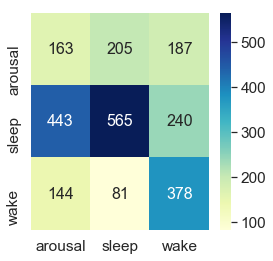


Classification Report:
-----------------------------
             precision    recall  f1-score   support

          0     0.2173    0.2937    0.2498       555
          1     0.6639    0.4527    0.5384      1248
          2     0.4696    0.6269    0.5369       603

avg / total     0.5122    0.4597    0.4714      2406



In [16]:
# Decision tree
from sklearn.tree import DecisionTreeClassifier

dtc = model_build(DecisionTreeClassifier(), X_train, y_train)
model_eval(dtc, X_test,y_test)

C:\Users\ailee\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


Accuracy:
-----------------------------
0.656691604322527

Confusion Matrix:
-----------------------------


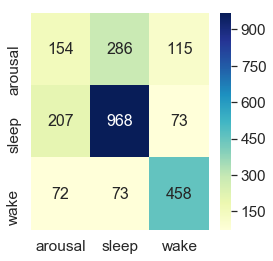


Classification Report:
-----------------------------
             precision    recall  f1-score   support

          0     0.3557    0.2775    0.3117       555
          1     0.7295    0.7756    0.7518      1248
          2     0.7090    0.7595    0.7334       603

avg / total     0.6381    0.6567    0.6457      2406



In [17]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rfc = model_build(RandomForestClassifier(n_estimators=20), X_train, y_train)
model_eval(rfc, X_test, y_test)

C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy:
-----------------------------
0.6974231088944306

Confusion Matrix:
-----------------------------


C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


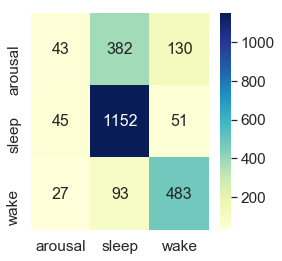


Classification Report:
-----------------------------
             precision    recall  f1-score   support

          0     0.3739    0.0775    0.1284       555
          1     0.7081    0.9231    0.8014      1248
          2     0.7274    0.8010    0.7624       603

avg / total     0.6358    0.6974    0.6364      2406



In [18]:
# Extreme Gradient Boosting
from xgboost import XGBClassifier

xgbc = model_build(XGBClassifier(n_estimators=150), X_train, y_train)
model_eval(xgbc, X_test, y_test)